In [68]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt




# Cruide Oil WTI 

## 7:3

In [69]:
keras.utils.set_random_seed(42)

In [70]:
df= pd.read_csv('../dataset/Crude Oil.csv')
df = df.dropna() # Drop missing values


### Các hàm chuyển kiểu dữ liệu cho Vol, Change, Date

In [71]:
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1].reset_index(drop=True)

In [72]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,46.54,45.80,47.78,44.35,850480,1.42
1,2019-01-03,47.09,46.26,47.49,45.35,788720,1.18
2,2019-01-04,47.96,46.90,49.22,46.65,817280,1.85
3,2019-01-07,48.52,48.30,49.79,48.11,819940,1.17
4,2019-01-08,49.78,48.73,49.95,48.31,765980,2.60
...,...,...,...,...,...,...,...
1289,2024-03-19,83.47,82.85,83.85,82.39,76810,0.91
1290,2024-03-20,81.68,83.20,83.21,81.44,26040,-2.14
1291,2024-03-21,81.07,81.49,81.92,80.30,266860,-0.75
1292,2024-03-22,80.63,80.84,81.45,80.42,231100,-0.54


In [73]:

# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,46.54,45.80,47.78,44.35,850480,1.42
1,2019-01-03,47.09,46.26,47.49,45.35,788720,1.18
2,2019-01-04,47.96,46.90,49.22,46.65,817280,1.85
3,2019-01-07,48.52,48.30,49.79,48.11,819940,1.17
4,2019-01-08,49.78,48.73,49.95,48.31,765980,2.60
...,...,...,...,...,...,...,...
1289,2024-03-19,83.47,82.85,83.85,82.39,76810,0.91
1290,2024-03-20,81.68,83.20,83.21,81.44,26040,-2.14
1291,2024-03-21,81.07,81.49,81.92,80.30,266860,-0.75
1292,2024-03-22,80.63,80.84,81.45,80.42,231100,-0.54


### Train, Test


In [74]:
# Split the data into training, testing, and validation sets
price = df['Price'].values
price = price.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Tạo và huấn luyện mô hình

In [75]:
X_train.shape

(885, 20, 1)

In [76]:
# Xây dựng mô hình
model = Sequential()

# Add convolutional layers
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Flatten layer
model.add(Flatten())

# Output layer
model.add(Dense(1, activation='linear')) # Linear activation for regression

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64)


Epoch 1/100


c:\Users\21521\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1903   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011     
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010    
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5659e-04 
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0530e-04 
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7228e-04 
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6905e-04 
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6847e-04 
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9968e-04 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5741e-04 
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6961e-04
Epoch 15/100
14/14 ━━━━━━━━━━

In [77]:
# Dự báo
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [78]:
# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mda = calculate_mda(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MDA trên tập test là:', test_score_mda, '%')

RMSE trên tập test là: 2.086378047593163
MAPE trên tập test là: 2.1467142265843346 %
MDA trên tập test là: 46.321525885558586 %


In [79]:
# Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [80]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1294,80.867241
1295,80.909477
1296,80.944969
1297,80.472008
1298,80.217873
1299,80.103920
1300,79.894905
1301,79.595062
1302,79.218124
1303,79.031731


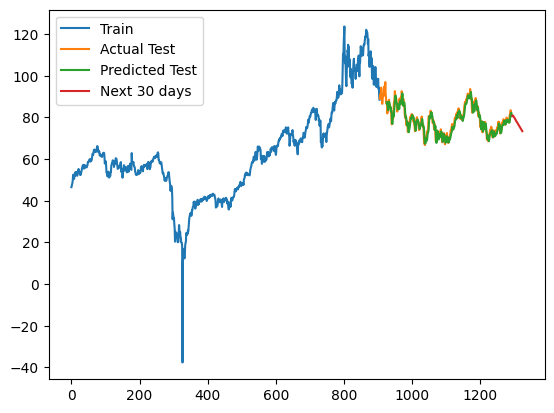

In [81]:
# Vẽ đồ thị các giá trị từ train tới validate và dự đoán 30 ngày sau
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()